# making an aggregate master dataframe for baseline model 10/30/19
this notebook is going to make standardized longformat dataframes for each dataframe that i will adjust for each model to. 

for my first pass, i will work to establish a baseline model by using:
the single "worst", or value that most indicates poor clinical outcomes, for each variable so each variable only has one row per patient. 


- make a long format table(ie variable, patient, time, value)
 - step1:Standardize all columns, format, etc. 
 - step2: Maybe make a long format table for each dataframe
 - step3: Impute
 
- combine features from each long table for 1 wide table (ie each patient has a row, each parameter has a column). 
 - feature select for "Clinical worst case" 



- Establish a baseline (ie train model initially), using an obvious baseline: last valid mesurement of a particular variable.   Will hope that it doesn’t perform too good or too bad. Second would be to pick an aggregate within a time window (over 3 days, or of each day, ie can change graunlarity).

- Next try temporal trend, maybe vector autoregression. 

So my first step would be to pick either the last recorded value for each variable or the ‘worst’ value, or ones that we might expect to indicate poor outcome (NEED TO CHOOSE)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob

from sklearn.externals.joblib import Memory
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp'", use "location='/tmp'" instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
#patients of interest from rotation_cohort_generation
from parameters import final_pt_df_v, date, repository_path

#patients of interest from rotation_cohort_generation
final_pt_df2 = final_pt_df_v #pd.read_csv('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/raw/csv/%s_final_pt_df2.csv'%(most_updated_patient_df), index_col=0)
del(final_pt_df_v)

patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]


time: 1.15 s


In [3]:
final_pt_df2['icustay_id'].nunique() #14478

19633

time: 5.97 ms


In [4]:
#import all clinical variables
##ensure they are the versions with UOM

time: 754 µs


In [5]:
from parameters import lower_window, upper_window, folder, date, time_col, time_var, patient_df

#importing in all clinical_variable files
# # ##24 hr sensitivity
# # #importing in all clinical_variable files
# lower_window=0
# upper_window=1
# time_col="charttime"
# time_var="t_0"
# folder="24_hr_window"
# timewindowdays="24"
# date= '09062019'
# patient_df= final_pt_df2

# #48 hr sensitivity
# lower_window=0
# upper_window=2
# time_var="t_0"
# folder="48_hr_window"
# timewindowdays="48"
# date='16052019'
# time_col="charttime"
# time_var= 't_0'
# patient_df= final_pt_df2

# # # 72 hr
# lower_window=0
# upper_window=3
# folder="72_hr_window"
# date='11062019'
# time_col="charttime"
# time_var= 't_0'
# timewindowdays="72"

time: 12.3 ms


In [6]:
#import all cleaned or 'prepped' clinical variable csv
allFiles = glob.glob(str(repository_path)+ '/data/cleaned/%s/'%(folder) + "{}_*.csv".format(date))
allFiles

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_phenylephrine_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_pt_info_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_bg_ART_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_sofa_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_rrt_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_sum_elix_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_ventcategory_prepped.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned/72_hr_window/10102019_pafaRatio_prepped.

time: 7.21 ms


In [47]:
save_path= str(repository_path)+'/data/cleaned_merged/'
def save_df(df, df_name='default', save_path=save_path, add_subfolder=False):
    #uses the date and supplied df name and saves to the savepath specified above.
    if df_name == 'default':
        df_name= "%s"%(df)
    
    address=save_path+'%s/'%(folder)
    if not os.path.exists(address):
        print(address)
        os.makedirs(address)
    pd.DataFrame(df).to_csv(Path(address+'%s_%s_cleaned_merged.csv' %(date, df_name)))

time: 6.12 ms


In [8]:
os.getcwd()

'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/notebooks'

time: 2.96 ms


In [9]:
#making a dictionary of all my dataframes for easier cycling through

df_list=[]
for element in allFiles:
    df_list.append(element.split('{}_'.format(date))[1].split('_prepped.csv')[0]) #making an list of all my dataframes in order they appear in file

dfs = {}
i=0
for name in df_list:
    dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


time: 16.6 s


In [10]:
#all of the column names 
for element in df_list:
    print(element,':',list(dfs[element]))

phenylephrine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
pt_info : ['icustay_id', 'subject_id', 't_0', 'label', 'value', 'delta', 'uom']
bg_ART : ['delta', 'hadm_id', 'icustay_id', 'label', 'subject_id', 't_0', 'uom', 'value']
sofa : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
rrt : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
sum_elix : ['subject_id', 'hadm_id', 'icustay_id', 'value', 'label', 'delta', 'uom', 't_0']
ventcategory : ['icustay_id', 'delta', 'value', 'uom', 't_0', 'label']
pafaRatio : ['icustay_id', 'hadm_id', 't_0', 'value', 'delta', 'uom', 'label']
cancer_elix : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
dobutamine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
gcs : ['subject_id', 'hadm_id', 'icustay_id', 'delta', 'label', 'value', 't_0', 'uom']
dopamine : ['icustay_id', 't_0', 'value', 'label', 'uom', 'delta']
weight : ['icustay_id', 'value', 'uom', 'label', 'delta', 't_0']
height :

## standardizing columns

#### adding icustay_id, dropping hadm_id

In [11]:
##dropping hadm_id from all:
list1=[]
for element in df_list:
    if 'hadm_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('hadm_id', axis=1)

time: 724 ms


In [12]:
##dropping subject_id from all:
list1=[]
for element in df_list:
    if 'subject_id' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('subject_id', axis=1)

time: 571 ms


In [13]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

phenylephrine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
pt_info : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
bg_ART : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
rrt : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
sum_elix : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
cancer_elix : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
dobutamine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
dopamine : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
weight : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
height : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
labs : ['delta', 'icustay_id', 'label', 't_0', 'uom', 'value']
norep

In [14]:
#dropping charttime, endtime and first_charttime
list1=[]
list2=[]
for element in df_list:
    if 'charttime' in (list(dfs[element])):
        list1.append(element)
    if 'endtime' in (list(dfs[element])):
        list2.append(element)

for element in list1:
    dfs[element]= dfs[element].drop('charttime', axis=1)

for element in list2:
    dfs[element]= dfs[element].drop('endtime', axis=1)
    
#dfs['rrt']= dfs['rrt'].drop('first_charttime', axis=1)

time: 520 ms


In [15]:
#converting valuenum and value to same label
list1=[]

for element in df_list:
    if 'valuenum' in (list(dfs[element])):
        list1.append(element)

for element in list1:
    dfs[element]= dfs[element].rename(index=str, columns={'valuenum':'value'})


time: 204 ms


In [16]:
del(list1,list2)

time: 806 µs


In [17]:
def label_lower(df_name):
    dfs[df_name]['label']= dfs[df_name]['label'].apply(lambda x: x.lower())

time: 1.01 ms


In [18]:
#turning all labels to lowercase
for element in df_list:
    label_lower(element)


time: 3.09 s


In [19]:
#adding a df source table label to each df. 
for element in df_list:
    dfs[element]['source']=element

#adding a patient id to each

for element in df_list:
    dfs[element]= pd.merge(dfs[element], final_pt_df2[['icustay_id','subject_id']], how='left')
    

time: 3.44 s


In [20]:
#all of the column names 
for element in df_list:
    print(element,':',sorted(list(dfs[element])))

phenylephrine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
pt_info : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
bg_ART : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
sofa : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
rrt : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
sum_elix : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
ventcategory : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
pafaRatio : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
cancer_elix : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
dobutamine : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
gcs : ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']
d

In [21]:
for element in df_list:
    print(element,'column that dont belong:', [x for x in list(dfs[element]) if x not in ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value']])
    print(element,'column that are missing:',[x for x in ['delta', 'icustay_id', 'label', 'source', 'subject_id', 't_0', 'uom', 'value'] if x not in list(dfs[element])])

phenylephrine column that dont belong: []
phenylephrine column that are missing: []
pt_info column that dont belong: []
pt_info column that are missing: []
bg_ART column that dont belong: []
bg_ART column that are missing: []
sofa column that dont belong: []
sofa column that are missing: []
rrt column that dont belong: []
rrt column that are missing: []
sum_elix column that dont belong: []
sum_elix column that are missing: []
ventcategory column that dont belong: []
ventcategory column that are missing: []
pafaRatio column that dont belong: []
pafaRatio column that are missing: []
cancer_elix column that dont belong: []
cancer_elix column that are missing: []
dobutamine column that dont belong: []
dobutamine column that are missing: []
gcs column that dont belong: []
gcs column that are missing: []
dopamine column that dont belong: []
dopamine column that are missing: []
weight column that dont belong: []
weight column that are missing: []
height column that dont belong: []
height colu

In [22]:
pd.to_timedelta(dfs['norepinephrine']['delta']).describe()

count                     48703
mean     0 days 19:45:10.416196
std      0 days 21:00:00.185295
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 13:15:00
75%             1 days 10:30:00
max             3 days 00:00:00
Name: delta, dtype: object

time: 187 ms


In [23]:
pd.to_timedelta(dfs['norepinephrine']['delta']).describe()

count                     48703
mean     0 days 19:45:10.416196
std      0 days 21:00:00.185295
min             0 days 00:00:00
25%             0 days 00:00:00
50%             0 days 13:15:00
75%             1 days 10:30:00
max             3 days 00:00:00
Name: delta, dtype: object

time: 160 ms


# converting data formats

# looking at measured values

In [25]:
len(df_list)

23

time: 2.57 ms


In [27]:
def value_viewer(df_name):
    return(dfs[df_name]['label'].unique())

time: 1.4 ms


In [28]:
value_viewer('bg_ART')

array(['pco2'], dtype=object)

time: 3.78 ms


In [29]:
value_viewer('bg_all')

array(['calcium', 'lactate', 'ph', 'potassium', 'temperature', 'glucose',
       'hemoglobin', 'chloride', 'sodium', 'bicarbonate'], dtype=object)

time: 16.6 ms


In [30]:
#value_viewer('uti')

time: 480 µs


In [31]:
value_viewer('labs')


array(['bicarbonate', 'bilirubin', 'chloride', 'creatinine', 'glucose',
       'potassium', 'sodium', 'bun', 'hemoglobin', 'platelet', 'wbc',
       'inr', 'ptt', 'lactate', 'bands'], dtype=object)

time: 55.4 ms


In [32]:
value_viewer('vitals')

array(['meanartpress', 'sysbp', 'heartrate', 'resprate', 'spo2',
       'temperature', 'glucose', 'diasbp'], dtype=object)

time: 399 ms


In [33]:
value_viewer('pt_info')

array(['yearsold', 'gender', 'ethnicity'], dtype=object)

time: 3.96 ms


In [34]:
list(dfs)

['phenylephrine',
 'pt_info',
 'bg_ART',
 'sofa',
 'rrt',
 'sum_elix',
 'ventcategory',
 'pafaRatio',
 'cancer_elix',
 'dobutamine',
 'gcs',
 'dopamine',
 'weight',
 'height',
 'labs',
 'norepinephrine',
 'vasopressin',
 'o2_flow',
 'nit',
 'epinephrine',
 'vitals',
 'bg_all',
 'leuk']

time: 3.03 ms


# combining data

In [35]:
set(value_viewer('labs')) & set(value_viewer('bg_all'))

{'bicarbonate',
 'chloride',
 'glucose',
 'hemoglobin',
 'lactate',
 'potassium',
 'sodium'}

time: 74.5 ms


In [36]:
set(value_viewer('labs')) & set(value_viewer('vitals'))

{'glucose'}

time: 410 ms


In [37]:
set(value_viewer('bg_all')) & set(value_viewer('vitals'))

{'glucose', 'temperature'}

time: 374 ms


# combining all df

In [38]:
# making one big dataframe via pd. concat
big_df= pd.concat(dfs.values(), sort=False).sort_values(['icustay_id','delta','label','source'], ascending=True)
#converting delta to time delta, to datetime rounded to 2 minutes, and back to time delta (more efficient than rounding timedeltas)
big_df['delta']= pd.to_timedelta(big_df['delta'])
big_df['delta']= pd.to_datetime(big_df['delta']).dt.round('2min')
big_df['delta']= pd.to_timedelta(big_df['delta'])

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


time: 54.7 s


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  


In [100]:
len(big_df)

5663255

time: 2.3 ms


In [39]:
len(big_df)

10407916

time: 1.78 ms


In [40]:
big_df.drop_duplicates(subset=['icustay_id','label','value','delta',], keep='last', inplace=True) #7638425  -> 7315304 at 2 min. 

time: 5.2 s


In [102]:
len(big_df)

5427646

time: 2.13 ms


In [103]:
#big_df['sum_elix']

time: 727 µs


In [42]:
big_df.groupby('label')['value'].describe() 

,count,unique,top,freq
label,,,,
bands,19633,3,absent,16231
bicarbonate,85733,100,24,6734
bilirubin,24769,635,0.4,1806
bun,85334,346,14,2405
calcium,42744,199,1.13,2150
cancer_elix,19633,2,0,17212
chloride,94196,144,106,5698
creatinine,85693,294,0.7,6713
daily_sofa,52281,24,1,9490


time: 3.69 s


In [104]:
#big_df.groupby('label')['value'].describe() #14478 icustay_id's

,count,unique,top,freq
label,,,,
bands,14181,3,absent,11919
bicarbonate,45045,56,23,3720
bilirubin,13459,370,0.4,1163
bun,44760,198,14,1345
calcium,22687,167,1.13,1158
cancer_elix,14181,2,0,12439
chloride,49703,86,106,3183
creatinine,44947,182,0.7,3699
daily_sofa,30669,23,1,5664


time: 1.93 s


In [43]:
big_df['label'].unique()

array(['bands', 'cancer_elix', 'daily_sofa', 'dobutamine', 'dopamine',
       'epinephrine', 'heartrate', 'height', 'norepinephrine', 'o2_flow',
       'pao2fio2ratio', 'pco2', 'phenylephrine', 'resprate', 'spo2',
       'sum_elix', 'vasopressin', 'vent_recieved', 'weight', 'diasbp',
       'meanartpress', 'sysbp', 'rrt', 'bicarbonate', 'bilirubin', 'bun',
       'chloride', 'creatinine', 'glucose', 'hemoglobin', 'inr',
       'platelet', 'potassium', 'ptt', 'sodium', 'wbc', 'temperature',
       'ph', 'leukocyte', 'nitrite', 'lactate', 'ethnicity', 'gender',
       'yearsold', 'calcium', 'mingcs'], dtype=object)

time: 869 ms


In [44]:
big_df[big_df['label']=='leukocyte'].head()

,icustay_id,t_0,value,label,uom,delta,source,subject_id
13546,200001.0,2181-11-26,Neg/Not_tested,leukocyte,pos/neg category,1 days,leuk,55973
9126,200003.0,2199-08-04,Neg/Not_tested,leukocyte,pos/neg category,1 days,leuk,27513
9527,200012.0,2153-12-23,Neg/Not_tested,leukocyte,pos/neg category,1 days,leuk,28448
3120,200014.0,2105-02-17,Neg/Not_tested,leukocyte,pos/neg category,1 days,leuk,9514
7162,200019.0,2178-07-09,Neg/Not_tested,leukocyte,pos/neg category,1 days,leuk,21789


time: 706 ms


## last minute data cleaning

In [46]:
#removing firstpos else neg ssc col
big_df=big_df.loc[:,list(big_df.columns!="first_pos_else_neg_ssc")]

time: 943 ms


In [48]:
save_df(big_df, 'longdf')

/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-opensource/data/cleaned_merged/72_hr_window/
time: 3min 14s


In [56]:
del big_df
del dfs

time: 272 ms


#### making a patient missingness visualization

In [49]:
#big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].agg(['min'])
big_agg= big_df.groupby(['icustay_id','label'], as_index=False)['value'].size()
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 1.93 s


In [50]:
big_agg_count= big_agg.reset_index().pivot(index='icustay_id',columns='label', values=0)#, levels='icustay_id')

time: 343 ms


In [51]:
sns.set(rc={'figure.figsize':(25,15)})

time: 1.92 ms


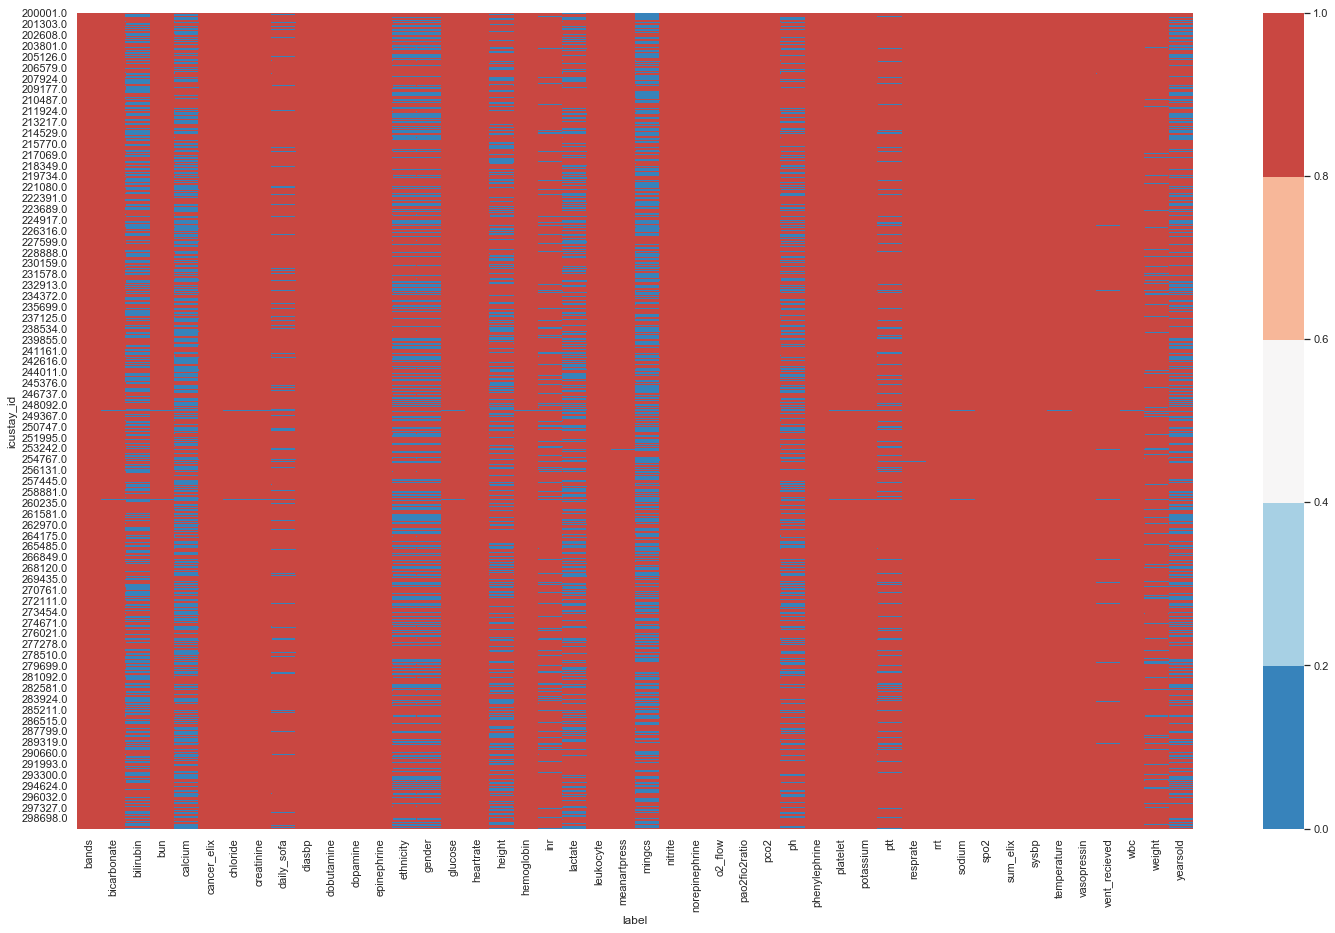

time: 3.38 s


In [52]:
#big_agg_min

#%matplotlib inline
sns.set(rc={'figure.figsize':(25,15)})
big_agg_count= big_agg_count.fillna(0)
big_agg_count = big_agg_count[big_agg_count.columns].astype(float) 


sns.heatmap(big_agg_count,vmin=0, vmax=1, cmap=sns.color_palette("RdBu_r", 5))

In [55]:
#deleting df's for memory once saved
del big_df, big_agg_count, big_agg, dfs

time: 1.34 ms


In [65]:
# big_agg_count[big_agg_count>0] =1
# big_agg_pt_missing= big_agg_count.T.apply(lambda x:100*(len(list(big_agg_count))-sum(x))/len(list(big_agg_count)))
# big_agg_pt_missing= pd.DataFrame(big_agg_pt_missing).rename(index=str, columns={0:'%_of_values_missing'})

time: 713 µs


In [66]:
# big_agg_pt_missing.sort_values('%_of_values_missing',ascending=False).plot()

time: 464 µs
